In [77]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
import time

In [10]:
# Load data

with open("data/2022-08-02-01.json", "r") as file:
    data_text = file.read()
    data_dict = json.loads(data_text)
    data = np.array(data_dict["trace_array"])

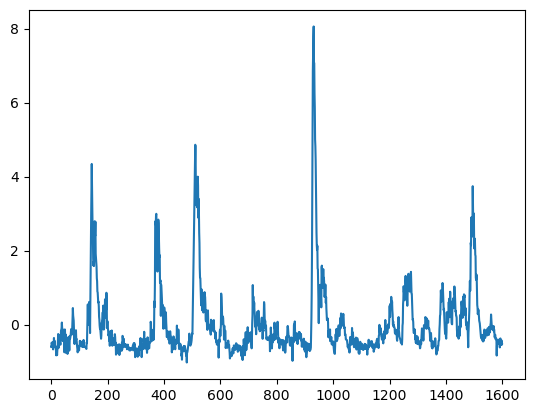

In [18]:
plt.plot(data[15])

In [188]:
152 * 20

3040

In [204]:
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.first_layer = nn.Linear(3040, 1000)
        self.first_act = nn.Sigmoid()
        self.second_layer = nn.Linear(1000, 500)
        self.second_act = nn.Sigmoid()
        self.third_layer = nn.Linear(500, 250)
        self.third_act = nn.Sigmoid()

        self.process = nn.Sequential(self.first_layer,
                                     self.first_act,
                                     self.second_layer,
                                     self.second_act,
                                     self.third_layer,
                                     self.third_act)
        
        self.final_layer = nn.Linear(250, 152)

    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 3040))
        x = self.process(x)
        x = self.final_layer(x)
        return x

In [205]:
data.shape

(152, 1600)

In [206]:
# Window Sample

simple_x = []
simple_y = []

for i in range(1580):
    window = data[:, i:i+20]
    simple_x.append(window)
    simple_y.append(data[:, i+20])

simple_x = np.array(simple_x)
simple_y = np.array(simple_y)

In [207]:
x_train, x_test, y_train, y_test = train_test_split(simple_x, simple_y, test_size=0.2, random_state=5, shuffle=True)

In [208]:
x_train.shape, y_train.shape

((1264, 152, 20), (1264, 152))

In [209]:
def train(model, criterion, optimizer, points, labels, epoches=5, do_print=True):
    
    total_start_time = time.time()
    loss = -1
    for i in range(1,epoches+1):
        start_time = time.time()
        optimizer.zero_grad()
        y = model(points)
        loss = criterion(y, labels)
        loss.backward()
        optimizer.step()
        end_time = time.time()
        if(i % 1 == 0 and do_print):
            print(f"Loss {loss.item()}, Time {end_time - start_time}")
            
    total_end_time = time.time()
    total_time_taken = total_end_time - total_start_time
    if(do_print):
        print(f"Total Time {total_time_taken}")
        
    final_loss = loss.item()
    
    return (total_time_taken, final_loss)

In [210]:
# Training Setup

torch.manual_seed(4687)
model = SimpleNetwork()

optimiser = optim.Adam(model.parameters(), lr=0.001)
crit = nn.MSELoss()

x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

x_train_tensor.shape[0]

1264

In [221]:
time_taken, final_loss = train(model, crit, optimiser, x_train_tensor, y_train_tensor, epoches=500, do_print=True)

Loss 0.10751786082983017, Time 0.09347677230834961
Loss 0.10733354836702347, Time 0.05004572868347168
Loss 0.10707845538854599, Time 0.05738186836242676
Loss 0.1067846268415451, Time 0.052171945571899414
Loss 0.1065228134393692, Time 0.055764198303222656
Loss 0.10632678121328354, Time 0.05197548866271973
Loss 0.10616424679756165, Time 0.05030107498168945
Loss 0.10597596317529678, Time 0.04972267150878906
Loss 0.1057368591427803, Time 0.05785107612609863
Loss 0.1054752841591835, Time 0.0497586727142334
Loss 0.10523919016122818, Time 0.05084562301635742
Loss 0.10504157841205597, Time 0.05069708824157715
Loss 0.10486052185297012, Time 0.056296348571777344
Loss 0.10466551035642624, Time 0.05196404457092285
Loss 0.1044488325715065, Time 0.049416303634643555
Loss 0.1042226254940033, Time 0.049909114837646484
Loss 0.10400056838989258, Time 0.0558476448059082
Loss 0.10379025340080261, Time 0.05322456359863281
Loss 0.10358831286430359, Time 0.04863882064819336
Loss 0.10339172184467316, Time 0.0

In [288]:
x_test_tensor = torch.from_numpy(simple_x).float()
output = model(x_test_tensor).detach().numpy()

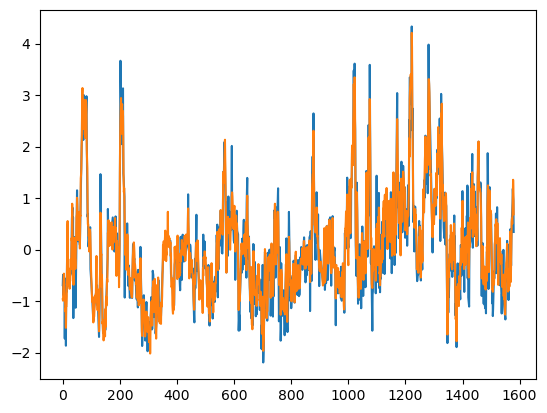

In [289]:
plt.plot(simple_y[:, 0])
plt.plot(output[:, 0])

In [231]:
test_tensor = torch.from_numpy(x_test).float()
test_y_tensor = torch.from_numpy(y_test).float()
output = model(test_tensor)

In [232]:
crit(test_y_tensor, output)

tensor(0.1867, grad_fn=<MseLossBackward0>)

In [283]:
# Far seeing / Close seeing

# Set window to 0 or -1 for different effect
window = simple_x[0]
window = window.reshape(1, 152, 20)

line = []

for i in range(1000):
    input = torch.from_numpy(window).float()
    out = model(input).detach().numpy().reshape(1, 152, 1)
    line.append(out)
    window = np.concatenate((window[:, :, 1:], out), axis=2) 

line = np.array(line).reshape(1000, 152)
ext_line = np.concatenate((simple_x[0].T, line), axis = 0).T
combined = np.concatenate((data.T, line), axis = 0).T
line = line.T

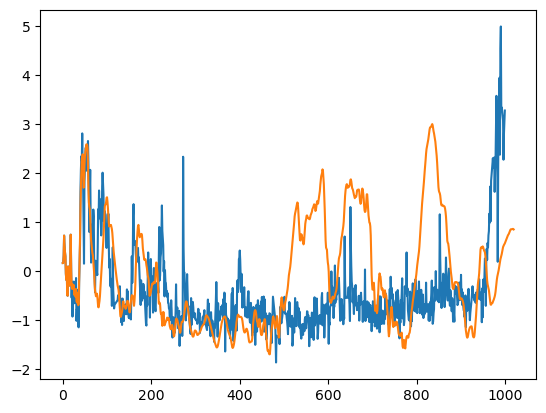

In [286]:
plt.plot(data[60, :1000])
plt.plot(ext_line[60])